In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import re
import string

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [59]:
train_df = pd.read_csv("data/train.csv", sep=";")
test_df = pd.read_csv("data/test.csv", sep=";")
eval_df = pd.read_csv("data/eval.csv", sep=";")

train_df.head()

,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [60]:
train_df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [61]:
train_df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

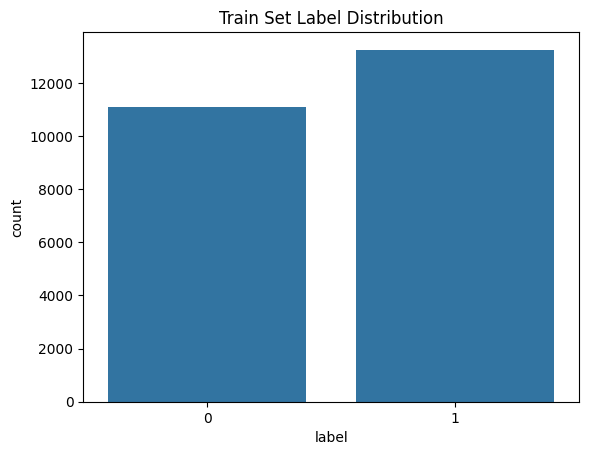

In [62]:
sns.countplot(x=train_df["label"])
plt.title("Train Set Label Distribution")
plt.show()

In [63]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\n", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text)
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)
eval_df["clean_text"] = eval_df["text"].apply(clean_text)


In [64]:
tfidf = TfidfVectorizer(max_features=20000)

X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_test_tfidf = tfidf.transform(test_df["clean_text"])
X_eval_tfidf = tfidf.transform(eval_df["clean_text"])


In [65]:
y_train = train_df["label"]
y_test = test_df["label"]
y_eval = eval_df["label"]

In [66]:
class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [67]:
train_ds = TfidfDataset(X_train_tfidf, y_train)
test_ds = TfidfDataset(X_test_tfidf, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [68]:
class NewsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

model = NewsClassifier(input_dim=X_train_tfidf.shape[1])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [69]:
def train_epoch():
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

for epoch in range(5):
    train_epoch()
    print(f"Epoch {epoch+1} complete.")

Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.


In [70]:
model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())

print("Accuracy:", accuracy_score(y_test, all_preds))
print(classification_report(y_test, all_preds))

Accuracy: 0.9751139583589996
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3753
           1       0.98      0.98      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.98      0.98      0.98      8117



In [71]:
class ComplexNewsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256], dropout=0.5):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for h in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
            prev_dim = h
        self.out = nn.Linear(prev_dim, 2)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.out(x)

model = ComplexNewsClassifier(input_dim=X_train_tfidf.shape[1])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [72]:
for epoch in range(5):
    train_epoch()
    print(f"Epoch {epoch+1} complete.")

Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.


In [73]:
model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())

print("Accuracy:", accuracy_score(y_test, all_preds))
print(classification_report(y_test, all_preds))

Accuracy: 0.973389183195762
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3753
           1       0.97      0.98      0.98      4364

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117



In [74]:
class BasicNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.fc(x)

model = BasicNewsClassifier(input_dim=X_train_tfidf.shape[1])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [75]:
for epoch in range(5):
    train_epoch()
    print(f"Epoch {epoch+1} complete.")

Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.


In [76]:
model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())

print("Accuracy:", accuracy_score(y_test, all_preds))
print(classification_report(y_test, all_preds))

Accuracy: 0.9637797215720094
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3753
           1       0.96      0.97      0.97      4364

    accuracy                           0.96      8117
   macro avg       0.96      0.96      0.96      8117
weighted avg       0.96      0.96      0.96      8117

